# Laboratorio 1 – Detección de Phishing
## Parte 2: Implementación de Modelos de Machine Learning

**Universidad del Valle de Guatemala**  
**CC3094 – Security Data Science | Semestre I - 2026**  
**Autores:** Fabiola Contreras (22787), María José Villafuerte (22129)  
**Docente:** Jorge Yass | **Sección:** 11

---

Este notebook implementa dos modelos de clasificación (**Random Forest** y **Logistic Regression**) para detectar URLs de phishing, utilizando las 7 características seleccionadas en la fase de ingeniería de características.

In [ ]:
# 0. Importación de librerías
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, accuracy_score, roc_curve, auc
)

# Configuración de visualización
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
np.random.seed(42)

print("Librerías importadas correctamente")

Librerías importadas correctamente


## 1. Carga y Preparación del Dataset

Se carga el dataset preprocesado (normalizado con StandardScaler) y se filtran las **7 características seleccionadas**:

| Característica | Justificación |
|---|---|
| `shannon_entropy` | Mide la aleatoriedad de caracteres en la URL; phishing presenta mayor entropía |
| `digit_ratio` | Proporción de dígitos; URLs con muchos números son sospechosas |
| `sensitive_words` | Presencia de palabras como "login", "verify", "account" |
| `url_length` | Longitud total; phishing tiende a usar URLs más largas para ocultar el dominio real |
| `domain_length` | Longitud del dominio; dominios falsos suelen ser más largos |
| `num_params` | Cantidad de parámetros en query string; URLs complejas son sospechosas |
| `special_chars` | Conteo de caracteres especiales no alfanuméricos |

In [ ]:
# 1. Carga del dataset preprocesado (normalizado)

DATA_PATH = '../feature engineering/dataset_phishing_preprocessed.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset cargado desde: {DATA_PATH}")
except FileNotFoundError:
    print(f"Archivo no encontrado en {DATA_PATH}")
# ── Características seleccionadas ──
SELECTED_FEATURES = [
    'shannon_entropy', 'digit_ratio', 'sensitive_words',
    'url_length', 'domain_length', 'num_params', 'special_chars'
]

# Verificar columnas
missing = [c for c in SELECTED_FEATURES + ['status'] if c not in df.columns]
if missing:
    raise ValueError(f"Columnas faltantes: {missing}")

df_selected = df[SELECTED_FEATURES + ['status']].copy()

print(f"\nDimensiones del dataset: {df_selected.shape}")
print(f"\nDistribución de clases:")
print(f"   Legítimas (0): {(df_selected['status'] == 0).sum()}")
print(f"   Phishing  (1): {(df_selected['status'] == 1).sum()}")
print(f"\nPrimeras 5 observaciones:")
df_selected.head()

Dataset cargado desde: ../feature engineering/dataset_phishing_preprocessed.csv

Dimensiones del dataset: (11430, 8)

Distribución de clases:
   Legítimas (0): 5715
   Phishing  (1): 5715

Primeras 5 observaciones:


,shannon_entropy,digit_ratio,sensitive_words,url_length,domain_length,num_params,special_chars,status
0,-1.132160,-0.594666,-0.341452,-0.436245,-0.194860,-0.284531,-0.489972,0
1,0.570316,1.875919,-0.341452,0.287212,0.176271,-0.284531,-0.489972,1
2,1.578933,1.092760,3.677903,1.173447,2.681407,2.642731,1.487912,1
3,-2.045956,-0.594666,-0.341452,-0.779888,-0.937123,-0.284531,-0.819619,0
4,-0.260735,-0.594666,-0.341452,-0.110690,-0.565991,-0.284531,0.004499,0


## 2. División del Dataset

Se divide en tres conjuntos según las proporciones indicadas:
- **Entrenamiento (55%):** ajuste de parámetros del modelo
- **Validación (15%):** optimización de hiperparámetros
- **Prueba (30%):** evaluación final imparcial

Se utiliza estratificación para mantener la proporción de clases y `random_state=42` para reproducibilidad.

In [ ]:
 
# 2. División del dataset: 55% train / 15% validation / 30% test

X = df_selected[SELECTED_FEATURES]
y = df_selected['status']

# Paso 1: Separar 70% (train+val) y 30% (test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Paso 2: Del 70%, separar train (55%) y val (15%) → ratio = 15/70 ≈ 0.2143
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15/0.70, random_state=42, stratify=y_train_val
)

print("." * 55)
print("DIVISIÓN DEL DATASET")
print("." * 55)
total = len(df_selected)
print(f"  Total:         {total}")
print(f"  Entrenamiento: {len(X_train)} ({len(X_train)/total*100:.1f}%)")
print(f"  Validación:    {len(X_val)} ({len(X_val)/total*100:.1f}%)")
print(f"  Prueba:        {len(X_test)} ({len(X_test)/total*100:.1f}%)")
print("." * 55)
print("\n  Balance de clases por conjunto:")
for name, ys in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    pct = (ys == 1).sum() / len(ys) * 100
    print(f"    {name}: {pct:.1f}% phishing / {100-pct:.1f}% legítimas")

.......................................................
DIVISIÓN DEL DATASET
.......................................................
  Total:         11430
  Entrenamiento: 6286 (55.0%)
  Validación:    1715 (15.0%)
  Prueba:        3429 (30.0%)
.......................................................

  Balance de clases por conjunto:
    Train: 50.0% phishing / 50.0% legítimas
    Val: 50.0% phishing / 50.0% legítimas
    Test: 50.0% phishing / 50.0% legítimas


In [ ]:
# Guardar cada split como archivo CSV

pd.concat([X_train, y_train], axis=1).to_csv('train_dataset.csv', index=False)
pd.concat([X_val, y_val], axis=1).to_csv('validation_dataset.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('test_dataset.csv', index=False)

print("Archivos CSV guardados:")
print("   train_dataset.csv")
print("   validation_dataset.csv")
print("   test_dataset.csv")

Archivos CSV guardados:
   train_dataset.csv
   validation_dataset.csv
   test_dataset.csv


## 3. Funciones Auxiliares de Evaluación

Se definen funciones reutilizables para calcular métricas y generar visualizaciones. En el contexto de detección de phishing:

- **TP (Verdadero Positivo):** URL de phishing correctamente detectada → usuario protegido
- **TN (Verdadero Negativo):** URL legítima correctamente clasificada → acceso permitido sin problemas
- **FP (Falso Positivo):** URL legítima marcada como phishing → bloqueo innecesario, frustración del usuario
- **FN (Falso Negativo):** URL de phishing no detectada → usuario expuesto al ataque, riesgo crítico

In [ ]:
# 3. Funciones auxiliares de evaluación

def evaluate_model(model, X, y_true, set_name, model_name):
    """
    Evalúa un modelo y retorna diccionario con métricas.
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return {
        'Modelo': model_name, 'Conjunto': set_name,
        'Accuracy':  accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall':    recall_score(y_true, y_pred),
        'F1-Score':  f1_score(y_true, y_pred),
        'AUC':       roc_auc,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'fpr': fpr, 'tpr': tpr
    }


def plot_confusion_matrix(results, ax):
    """Visualiza la matriz de confusión con contexto de phishing."""
    cm = np.array([[results['TN'], results['FP']],
                   [results['FN'], results['TP']]])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Legítima (0)', 'Phishing (1)'],
                yticklabels=['Legítima (0)', 'Phishing (1)'],
                annot_kws={'size': 14})
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Valor Real')
    ax.set_title(f"Matriz de Confusión\n{results['Modelo']} — {results['Conjunto']}", fontsize=12)


def plot_roc(results, ax):
    """Grafica la curva ROC."""
    ax.plot(results['fpr'], results['tpr'], color='darkorange', lw=2,
            label=f"ROC (AUC = {results['AUC']:.4f})")
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Aleatorio (AUC = 0.5)')
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)')
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)')
    ax.set_title(f"Curva ROC\n{results['Modelo']} — {results['Conjunto']}", fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)


def print_metrics(r):
    """Imprime métricas con explicación contextual."""
    print(f"\n{'.'*60}")
    print(f"{r['Modelo']} — Conjunto de {r['Conjunto']}")
    print(f"{'.'*60}")
    # Accuracy: proporción total de clasificaciones correctas
    print(f"  Accuracy:  {r['Accuracy']:.4f}  — Proporción de predicciones correctas")
    # Precision: de las URLs marcadas como phishing, ¿cuántas realmente lo son?
    # Alta precision = pocas falsas alarmas
    print(f"  Precision: {r['Precision']:.4f}  — De las alertas de phishing, ¿cuántas son reales?")
    # Recall: de todas las URLs de phishing reales, ¿cuántas detectamos?
    # Alto recall = pocos ataques no detectados
    print(f"  Recall:    {r['Recall']:.4f}  — De todo el phishing real, ¿cuánto detectamos?")
    # F1-Score: balance entre Precision y Recall
    print(f"  F1-Score:  {r['F1-Score']:.4f}  — Balance entre Precision y Recall")
    # AUC: capacidad general de discriminación del modelo
    print(f"  AUC:       {r['AUC']:.4f}  — Capacidad discriminativa general")
    print(f"{'.'*60}")
    print(f"  TP={r['TP']} (phishing detectado) | TN={r['TN']} (legítimo OK)")
    print(f"  FP={r['FP']} (falsa alarma)       | FN={r['FN']} (phishing NO detectado)")


def full_evaluation(model, X, y, set_name, model_name):
    """Ejecuta evaluación completa: métricas + gráficas."""
    r = evaluate_model(model, X, y, set_name, model_name)
    print_metrics(r)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_confusion_matrix(r, axes[0])
    plot_roc(r, axes[1])
    plt.tight_layout(pad=3.0)
    plt.show()
    return r

print("Funciones auxiliares definidas")

Funciones auxiliares definidas


---
## 4. Modelo 1: Random Forest

Random Forest es un ensemble de árboles de decisión que combina múltiples clasificadores mediante bagging. Es adecuado para detección de phishing porque:
- Captura **relaciones no lineales** entre las características de las URLs
- Es **resistente al overfitting** gracias al promedio de múltiples árboles
- Proporciona **importancia de variables**, útil para interpretar qué características discriminan mejor

### 4.1 Entrenamiento y Optimización de Hiperparámetros

Se utiliza `GridSearchCV` para encontrar la mejor combinación de hiperparámetros, evaluando con F1-Score (métrica que balancea precision y recall).

In [ ]:
# 4.1 Random Forest — Optimización de Hiperparámetros

print("Entrenando Random Forest con GridSearchCV...")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_param_grid, cv=3, scoring='f1', n_jobs=-1, refit=True
)
rf_grid.fit(X_train, y_train)

print(f"\nMejores hiperparámetros:")
for p, v in rf_grid.best_params_.items():
    print(f"   {p}: {v}")
print(f"\n   Mejor F1-Score (CV): {rf_grid.best_score_:.4f}")

rf_model = rf_grid.best_estimator_

Entrenando Random Forest con GridSearchCV...

Mejores hiperparámetros:
   max_depth: None
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 10
   n_estimators: 200

   Mejor F1-Score (CV): 0.7739


### 4.2 Evaluación en Conjunto de Validación


............................................................
Random Forest — Conjunto de Validación
............................................................
  Accuracy:  0.7994  — Proporción de predicciones correctas
  Precision: 0.8355  — De las alertas de phishing, ¿cuántas son reales?
  Recall:    0.7459  — De todo el phishing real, ¿cuánto detectamos?
  F1-Score:  0.7882  — Balance entre Precision y Recall
  AUC:       0.8769  — Capacidad discriminativa general
............................................................
  TP=640 (phishing detectado) | TN=731 (legítimo OK)
  FP=126 (falsa alarma)       | FN=218 (phishing NO detectado)


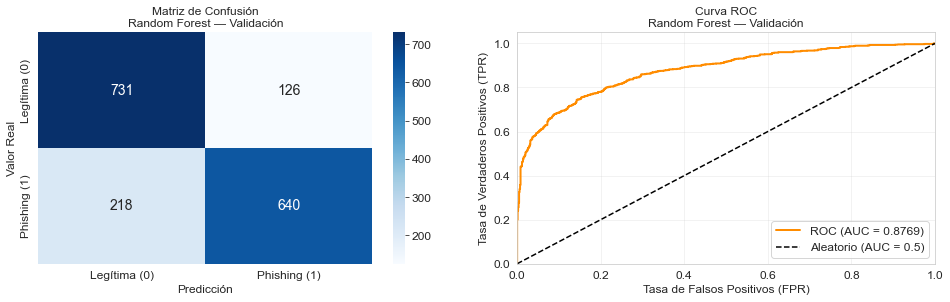

In [ ]:
# 4.2 Random Forest — Evaluación en VALIDACIÓN
rf_val = full_evaluation(rf_model, X_val, y_val, "Validación", "Random Forest")

### 4.3 Evaluación en Conjunto de Prueba


............................................................
Random Forest — Conjunto de Prueba
............................................................
  Accuracy:  0.7929  — Proporción de predicciones correctas
  Precision: 0.8239  — De las alertas de phishing, ¿cuántas son reales?
  Recall:    0.7450  — De todo el phishing real, ¿cuánto detectamos?
  F1-Score:  0.7825  — Balance entre Precision y Recall
  AUC:       0.8751  — Capacidad discriminativa general
............................................................
  TP=1277 (phishing detectado) | TN=1442 (legítimo OK)
  FP=273 (falsa alarma)       | FN=437 (phishing NO detectado)


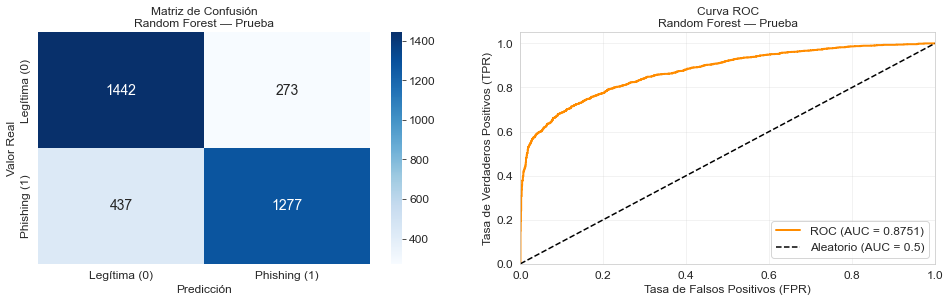

In [ ]:
# 4.3 Random Forest — Evaluación en PRUEBA
rf_test = full_evaluation(rf_model, X_test, y_test, "Prueba", "Random Forest")

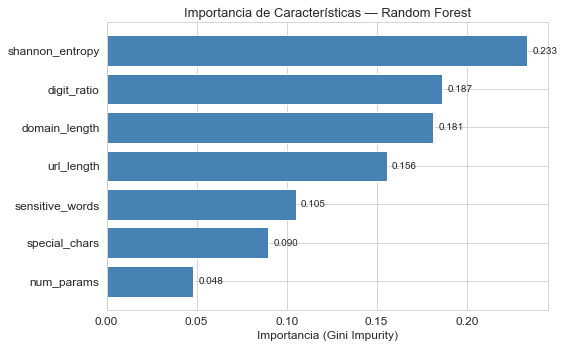

In [ ]:
# Importancia de Características — Random Forest
# Indica qué features contribuyen más a la clasificación de phishing

feat_imp = pd.DataFrame({
    'Característica': SELECTED_FEATURES,
    'Importancia': rf_model.feature_importances_
}).sort_values('Importancia', ascending=True)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(feat_imp['Característica'], feat_imp['Importancia'], color='steelblue')
ax.set_xlabel('Importancia (Gini Impurity)')
ax.set_title('Importancia de Características — Random Forest', fontsize=13)
for bar, val in zip(bars, feat_imp['Importancia']):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=10)
plt.tight_layout()
plt.show()